In [1]:
# Path to Netcdf files
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io as cio
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter, Gridliner
import math
from tqdm import tqdm

In [2]:
def haversine(lat1, lon1, lat2, lon2):
    # convert to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # calculate haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371 # Earth's radius in km
    return c * r

def find_nearest(lat, lon, lats, lons, n=9):
    distances = []
    for i in range(len(lats)):
        d = haversine(lat, lon, lats[i], lons[i])
        distances.append((d, i))
    distances.sort()
    nearest = [(lats[distances[i][1]], lons[distances[i][1]], distances[i][0]) for i in range(n)]
    return nearest

In [3]:
path='/home/jstreffi/thesis/data/'

grids=Dataset(path+'/grids.nc')
masks=Dataset(path+'/masks.nc')

# Loading data
lons = grids.variables['feom.lon'][0]
lats = grids.variables['feom.lat'][0]

lats_oifs = grids.variables['A096.lat'][0]
lons_oifs = grids.variables['A096.lon'][0]

mask_oifs = masks.variables['A096.msk'][0]

100%|█████████████████████████████████████████████████████████████| 40320/40320 [00:34<00:00, 1173.04it/s]


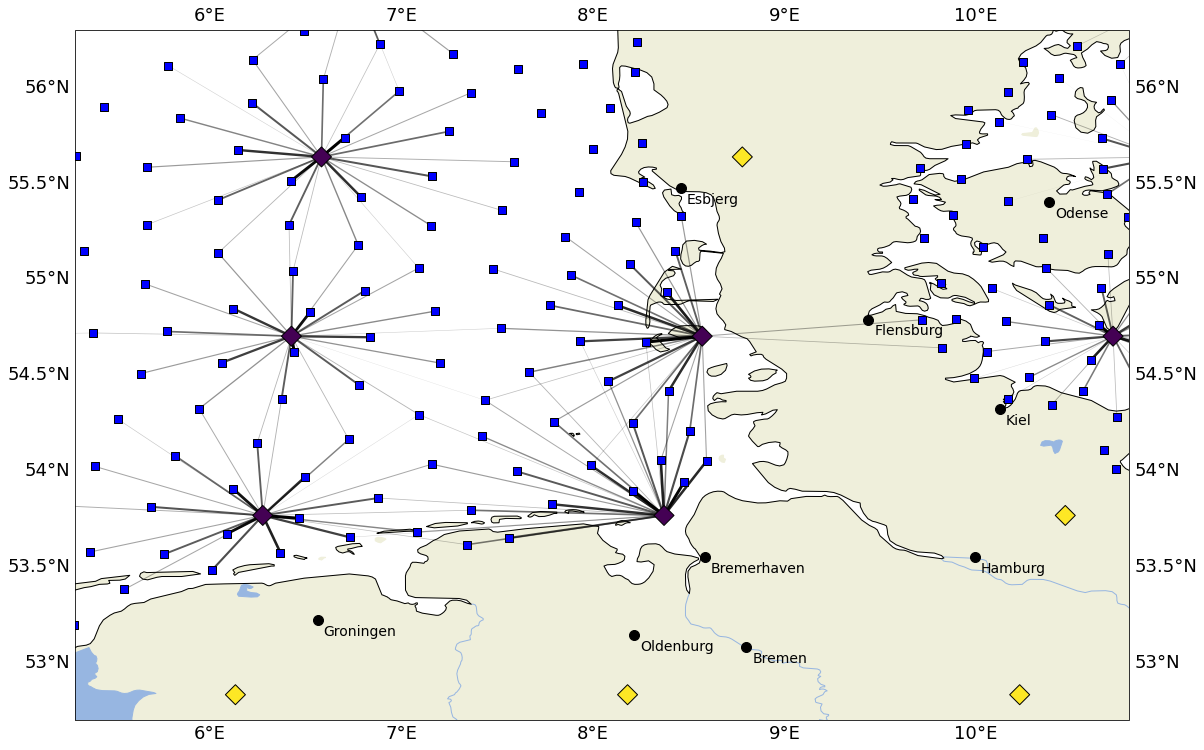

In [9]:
location='north_sea' # 'east med'
n_neighbour=25
plot_connections=True

if location =='north_sea':
    min_lon=5.3
    max_lon=10.8
    min_lat=52.7
    max_lat=56.3
    cities = {
    'Bremerhaven': (53.549999, 8.583333),
    'Bremen': (53.077939, 8.801709),
    'Hamburg': (53.551086, 9.993682),
    'Oldenburg': (53.141849, 8.215526),
    'Groningen': (53.219383, 6.566502),
    'Kiel': (54.320028, 10.126159),
    'Flensburg': (54.787977, 9.438211),
    'Esbjerg': (55.475701, 8.460622),
    'Odense': (55.402338, 10.380459)
    }
elif location =='azors':
    min_lon=-30
    max_lon=-24.5
    min_lat=36.7
    max_lat=40.3  
    cities = {}
elif location =='atlantic':
    min_lon=-30
    max_lon=-24.5
    min_lat=26.7
    max_lat=30.3  
    cities = {}
    
# Set up plot with cartopy feature
fig, ax = plt.subplots(figsize=((max_lon-min_lon)*3, (max_lat-min_lat)*3), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([min_lon, max_lon,min_lat, max_lat],crs=ccrs.PlateCarree())   
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.RIVERS)
ax.coastlines()

# Create grid lines and labels for latitude and longitude
gridlines = ax.gridlines(draw_labels=True, linewidth=0, color='gray', alpha=0.5, linestyle='--')
gridlines.xformatter = LongitudeFormatter()
gridlines.yformatter = LatitudeFormatter()

# Set the fontsize of the labels
gridlines.xlabel_style = {'size': 18}
gridlines.ylabel_style = {'size': 18}

# Find connection to nearest N neigbours for points inside the box
if plot_connections:
    for i in tqdm(range(len(lats_oifs))):
        if lats_oifs[i] > min_lat-2 and lats_oifs[i] < max_lat+2:
            if lons_oifs[i] > min_lon-2 and lons_oifs[i] < max_lon+2:
                if mask_oifs[i] == 0:
                    nearest=find_nearest(lats_oifs[i], lons_oifs[i], lats, lons,n=n_neighbour)
                    max_dist=0
                    for lat_lon in nearest:
                        max_dist = lat_lon[2]
                    for lat_lon in nearest:
                        lat_plot, lon_plot, distance = lat_lon
                        weigth = 1-(distance/max_dist)+nearest[0][2]/max_dist
                        ax.plot([lons_oifs[i], lon_plot],[lats_oifs[i], lat_plot], alpha=weigth, transform=ccrs.PlateCarree(), color='black', linewidth=weigth*3,zorder=1)

# Plot some 
if len(cities)>0:
    for city, coords in cities.items():
        ax.plot(coords[1], coords[0], 'o', markersize=10, markerfacecolor='black', markeredgecolor='black', transform=ccrs.Geodetic(),zorder=5)
        ax.text(coords[1]+0.03, coords[0]-0.08, city, fontsize=14, transform=ccrs.Geodetic(),zorder=4)

sc = ax.scatter(lons, lats, color='blue', alpha=1, s=80,marker='s', edgecolors= "black",transform=ccrs.PlateCarree(),zorder=2)
ax.scatter(lons_oifs, lats_oifs, c=mask_oifs, alpha=1, s=200, marker='D', edgecolors= "black", transform=ccrs.PlateCarree(),zorder=3)

plt.tight_layout()
plt.savefig('gauswgt_'+location+'_N'+str(n_neighbour)+'.png',dpi=300)